<a href="https://colab.research.google.com/github/Le119/Ontario-Lake-Fish-Classification/blob/Rita/1d%20cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import gc
import pickle
import random
import keras
from multiprocessing import Pool

import numpy as np
import pandas as pd
from keras import optimizers, losses, activations, models
from keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
from keras.layers import Dense, Input, Dropout, Convolution1D, MaxPool1D, GlobalMaxPool1D, GlobalAveragePooling1D, \
    concatenate
from keras.layers import BatchNormalization
import time
from sklearn.preprocessing import MinMaxScaler #to normalize data
from sklearn.metrics import classification_report, confusion_matrix, roc_curve
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, precision_score, recall_score
from sklearn.utils import class_weight
from numpy import random
import librosa
import seaborn as sns
import glob
import os
import pandas as pd
from PIL import Image
import numpy as np
from numpy import array
import matplotlib.pyplot as plt
from random import shuffle
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from itertools import islice

import tensorflow.keras
import tensorflow.keras.backend as k
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, LSTM, Activation, Masking, Dropout, Conv1D, GlobalAveragePooling1D, MaxPooling1D
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import History
from tensorflow.keras import callbacks
from tensorflow.keras.utils import to_categorical

In [2]:
from google.colab import drive
drive.mount('/content/drive')
train_x = pd.read_csv('/content/drive/My Drive/1d cnn/train_x.csv')
train_y = pd.read_csv('/content/drive/My Drive/1d cnn/train_y.csv')

test_x = pd.read_csv('/content/drive/My Drive/1d cnn/test_x.csv')
test_y = pd.read_csv('/content/drive/My Drive/1d cnn/test_y.csv')

train_x = train_x.drop(columns=['F90'])
train_y['spCode'] = train_y['spCode'].replace({81: 0, 91: 1})
test_x = test_x.drop(columns=['F90'])
test_y['spCode'] = test_y['spCode'].replace({81: 0, 91: 1})
train_x

Mounted at /content/drive


,PingNumber,F45,F45.5,F46,F46.5,F47,F47.5,F48,F48.5,F49,...,F255.5,F256,F256.5,F257,F257.5,F258,F258.5,F259,F259.5,F260
0,2,-51.883906,-50.687682,-49.154930,-47.831610,-47.501963,-47.621513,-48.302647,-48.820783,-48.814905,...,-42.638190,-52.131501,-53.226761,-47.989555,-43.924982,-38.815221,-35.966275,-36.042496,-39.732498,-52.289473
1,3,-51.959003,-55.728649,-59.848247,-60.120356,-56.642376,-53.812022,-52.441038,-51.838534,-51.705703,...,-43.315020,-45.975164,-45.784614,-43.718245,-41.881922,-40.639250,-40.030868,-40.287746,-41.955418,-45.922520
2,4,-53.306697,-51.950987,-51.574633,-51.861205,-53.392284,-55.861019,-60.224228,-66.635568,-63.037436,...,-43.008945,-42.785738,-43.531765,-46.529162,-49.003771,-44.891353,-42.649263,-43.256199,-45.531624,-47.861674
3,5,-59.155537,-71.011809,-65.652595,-57.157341,-53.449105,-51.470088,-50.793745,-50.667697,-50.881916,...,-46.447828,-47.202525,-51.994872,-51.869982,-46.095891,-44.595040,-46.438780,-51.199069,-54.489129,-50.613298
4,7,-51.614086,-50.469793,-49.307268,-48.853587,-49.561748,-50.722986,-52.797421,-55.923489,-60.806103,...,-56.231902,-52.437989,-53.857087,-53.008513,-45.770230,-43.078860,-44.826425,-48.540613,-42.296061,-39.494180
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22425,32038,-54.884293,-54.446204,-54.413926,-54.553740,-55.399341,-56.379572,-57.784809,-59.353553,-61.291813,...,-46.197590,-47.609206,-50.552585,-55.668406,-61.999940,-55.966158,-50.819286,-47.896003,-46.507354,-46.193601
22426,32039,-51.823375,-51.781682,-51.854890,-52.084483,-53.227665,-54.902839,-57.566828,-60.667566,-61.447595,...,-46.027192,-45.627467,-44.140907,-42.086533,-40.417371,-39.594686,-39.908467,-41.690496,-45.405581,-51.556597
22427,32040,-51.690936,-51.682713,-51.154561,-50.096501,-49.369743,-48.701385,-48.572656,-48.748769,-49.323572,...,-49.506046,-51.168895,-49.519677,-45.031857,-42.407511,-41.788474,-42.772722,-44.764299,-45.868336,-43.259383
22428,32042,-53.614887,-53.330611,-52.736278,-51.914548,-51.628067,-51.346102,-51.342424,-51.315546,-51.330315,...,-52.532168,-51.204442,-51.389220,-52.974341,-54.667792,-56.681928,-57.236816,-49.980295,-45.578381,-44.209698


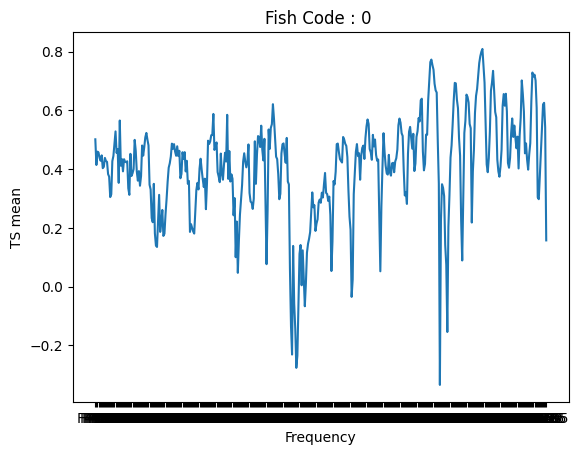

,PingNumber,F45,F45.5,F46,F46.5,F47,F47.5,F48,F48.5,F49,...,F255.5,F256,F256.5,F257,F257.5,F258,F258.5,F259,F259.5,F260
0,2,0.501415,0.414028,0.459400,0.456786,0.437833,0.428311,0.446676,0.403173,0.407960,...,0.608509,0.303991,0.297560,0.379132,0.467912,0.542801,0.620240,0.625682,0.542078,0.157258
1,3,0.499643,0.268473,0.157020,0.092182,0.155989,0.238594,0.328183,0.312318,0.321436,...,0.592466,0.470013,0.489844,0.487054,0.519728,0.490441,0.519318,0.531269,0.486519,0.333207
2,4,0.467849,0.377551,0.390977,0.337229,0.256205,0.175800,0.105330,-0.133173,-0.017732,...,0.599721,0.556024,0.548052,0.416031,0.339106,0.368380,0.454305,0.465251,0.397135,0.279619
3,5,0.329863,-0.172817,-0.007113,0.180094,0.254453,0.310366,0.375350,0.347568,0.346093,...,0.518206,0.436914,0.329389,0.281087,0.412855,0.376886,0.360214,0.288604,0.173251,0.203579
4,7,0.507781,0.420319,0.455093,0.426464,0.374319,0.333262,0.317979,0.189333,0.049053,...,0.286286,0.295726,0.281274,0.252320,0.421114,0.420410,0.400248,0.347727,0.478005,0.510853
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22425,32038,0.430630,0.305503,0.310689,0.257342,0.194318,0.159908,0.175177,0.086065,0.034516,...,0.524138,0.425947,0.366653,0.185114,0.009502,0.050469,0.251449,0.362063,0.372747,0.325716
22426,32039,0.502843,0.382439,0.383052,0.330604,0.261281,0.205165,0.181418,0.046504,0.029853,...,0.528177,0.479390,0.532313,0.528281,0.556871,0.520426,0.522358,0.500072,0.400285,0.177511
22427,32040,0.505968,0.385297,0.402856,0.389587,0.380240,0.395217,0.438945,0.405341,0.392735,...,0.445714,0.329950,0.393341,0.453863,0.506398,0.457451,0.451240,0.431711,0.388719,0.406802
22428,32042,0.460578,0.337715,0.358129,0.335646,0.310605,0.314166,0.359640,0.328064,0.332672,...,0.373984,0.328992,0.345037,0.253184,0.195457,0.029922,0.092106,0.315709,0.395966,0.380541


In [3]:
label_y = {k:v for k,v in zip(train_y.PingNumber.values, train_y.spCode)}
label_y_test = {k:v for k,v in zip(test_y.PingNumber.values, test_y.spCode)}
feats = train_x.columns.drop(['PingNumber'])
min_max_scaler = MinMaxScaler(feature_range=(-1,1))
train_x[feats] = min_max_scaler.fit_transform(train_x[feats])
test_x[feats] = min_max_scaler.transform(test_x[feats])

data_base = train_x.iloc[0]
plt.title('Fish Code : %s ' % label_y[data_base.PingNumber])
plt.ylabel('TS mean')
plt.xlabel('Frequency')
plt.plot(data_base.iloc[1:])
plt.show()
train_x

In [27]:
def print_results(y_test, y_pred, multi_class = False):
    #f1-score
    if multi_class == True:
        f1 = f1_score(y_test, y_pred, average="macro")
    else:
        f1 = f1_score(y_test, y_pred)
    print("F1 Score: ", f1)
    print(classification_report(y_test, y_pred))
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(12,12))
    plt.subplot(221)
    sns.heatmap(conf_matrix, fmt="d", annot=True, cmap='Blues')
    b, t = plt.ylim()
    plt.ylim(b+0.5, t-0.5)
    plt.title('Confusion Matrix')
    plt.ylabel('True Values')
    plt.xlabel('Predicted Values')
    #roc_auc_score
    if multi_class == False:
        model_roc_auc = roc_auc_score(y_test, y_pred)
        print ("Area Under Curve : ", model_roc_auc, "\n")
        fpr,tpr,thresholds = roc_curve(y_test, y_pred)
        gmeans = np.sqrt(tpr * (1-fpr))
        ix = np.argmax(gmeans)
        threshold = np.round(thresholds[ix],3)
        plt.subplot(222)
        plt.plot(fpr, tpr, color='darkorange', lw=1, label = "Auc : %.3f" %model_roc_auc)
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best Threshold:' + str(threshold))
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver operating characteristic')
        plt.legend(loc="lower right")


In [5]:
def gen_train(id_df, seq_length, seq_cols):
    """
        repeated overlay of chunks of size seq_length to prepare (samples, time steps, features)
        id_df = train dataframe
        seq_length = look back period
        seq_cols = feature columns
    """
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    lstm_array=[]
    for start, stop in zip(range(0, num_elements-seq_length+1), range(seq_length, num_elements+1)):
        lstm_array.append(data_array[start:stop, :])
    return np.array(lstm_array)


In [6]:
def gen_target(id_df, seq_length, label):
    # label is the column name string for target
    data_array = id_df[label].values
    num_elements = data_array.shape[0]
    return data_array[seq_length-1:num_elements+1]

In [7]:
def gen_test(id_df, seq_length, seq_cols, mask_value):
    """
        function to prepare test data into (samples, time steps, features)
        function only returns last sequence of data for every unit
        id_df = test dataframe
        seq_length = look back period
        seq_cols = feature columns
    """
    df_mask = pd.DataFrame(np.zeros((seq_length-1,id_df.shape[1])),columns=id_df.columns)
    df_mask[:] = mask_value
    id_df1 = pd.concat([df_mask, id_df],ignore_index=True)
    data_array = id_df1[seq_cols].values
    num_elements = data_array.shape[0]
    lstm_array=[]
    start = num_elements-seq_length
    stop = num_elements
    lstm_array.append(data_array[start:stop, :])
    return np.array(lstm_array)

In [8]:
sequence_length = 50
mask_value = -1
label = 'spCode'
x_train=np.concatenate(list(list(gen_test(train_x[train_x['PingNumber']==unit], sequence_length, feats, mask_value)) for unit in train_x['PingNumber'].unique()))
x_train.shape

(22430, 50, 425)

In [9]:
sequence_length = 1
y_train = np.concatenate(list(list(gen_target(train_y[train_y['PingNumber']==unit], sequence_length, label)) for unit in train_y['PingNumber'].unique()))
y_train.shape

(22430,)

In [19]:
sequence_length = 50
mask_value = -1
label = 'spCode'
x_test=np.concatenate(list(list(gen_test(test_x[test_x['PingNumber']==unit], sequence_length, feats, mask_value)) for unit in test_x['PingNumber'].unique()))
x_test.shape

(9613, 50, 425)

In [11]:
sequence_length = 1
y_test = np.concatenate(list(list(gen_target(test_y[test_y['PingNumber']==unit], sequence_length, label)) for unit in test_y['PingNumber'].unique()))
y_test.shape

(9613,)

In [12]:
nb_features = x_train.shape[2]
nb_out = 1

In [13]:
cls_wt= class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
cls_wt = {i : cls_wt[i] for i in range(2)}
cls_wt

{0: 0.7595151022619532, 1: 1.4633350730688934}

In [14]:
indices = np.arange(x_train.shape[0])
np.random.shuffle(indices)

x_train = x_train[indices]
y_train = y_train[indices]

In [20]:
sequence_length = 50
from keras.optimizers import SGD
opt = SGD(lr=0.0001)

history = History()
model = Sequential()
model.add(Conv1D(4, 3, activation = 'tanh', input_shape=(sequence_length, nb_features)))
model.add(BatchNormalization())
model.add(Conv1D(4, 3, activation='tanh'))
model.add(BatchNormalization())
model.add(MaxPooling1D(2))
model.add(Conv1D(8, 3, activation='tanh'))
model.add(BatchNormalization())
model.add(Conv1D(8, 3, activation='tanh'))
model.add(MaxPooling1D(2))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(units=1, activation='sigmoid'))
model.compile(loss="binary_crossentropy", optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 48, 4)             5104      
                                                                 
 batch_normalization_4 (Batc  (None, 48, 4)            16        
 hNormalization)                                                 
                                                                 
 conv1d_5 (Conv1D)           (None, 46, 4)             52        
                                                                 
 batch_normalization_5 (Batc  (None, 46, 4)            16        
 hNormalization)                                                 
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 23, 4)            0         
 1D)                                                             
                                                      

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [21]:
%%time
# fit the model
np.random.shuffle(x_train)
model.fit(x_train, y_train, epochs=4, batch_size=20, validation_split=0.1, verbose=1, class_weight=cls_wt,
          callbacks=[history, callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=3,
                                                      verbose=0, mode='auto')])

Epoch 1/4
1010/1010 [==============================] - 8s 6ms/step - loss: 0.6925 - accuracy: 0.5256 - val_loss: 0.6963 - val_accuracy: 0.3553
Epoch 2/4
1010/1010 [==============================] - 5s 5ms/step - loss: 0.6925 - accuracy: 0.5386 - val_loss: 0.6917 - val_accuracy: 0.6447
Epoch 3/4
1010/1010 [==============================] - 5s 5ms/step - loss: 0.6925 - accuracy: 0.6030 - val_loss: 0.6900 - val_accuracy: 0.6447
Epoch 4/4
1010/1010 [==============================] - 5s 5ms/step - loss: 0.6925 - accuracy: 0.6373 - val_loss: 0.6926 - val_accuracy: 0.6447
CPU times: user 1min 1s, sys: 8.61 s, total: 1min 10s
Wall time: 29.3 s


Text(0.5, 1.0, 'Loss')

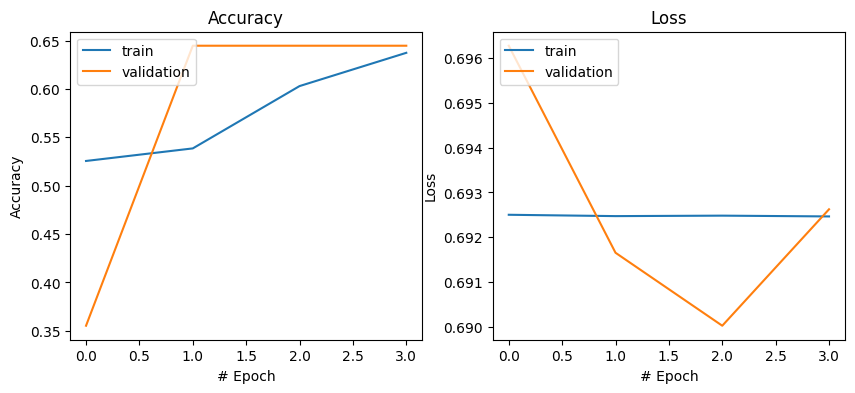

In [22]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
# Accuracy
ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('# Epoch')
ax[0].legend(['train', 'validation'], loc='upper left')
ax[0].set_title('Accuracy')
# Loss
ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('# Epoch')
ax[1].legend(['train', 'validation'], loc='upper left')
ax[1].set_title('Loss')

701/701 [==============================] - 2s 3ms/step
F1 Score:  0.0
              precision    recall  f1-score   support

           0       0.66      1.00      0.79     14766
           1       0.00      0.00      0.00      7664

    accuracy                           0.66     22430
   macro avg       0.33      0.50      0.40     22430
weighted avg       0.43      0.66      0.52     22430

Area Under Curve :  0.5 



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


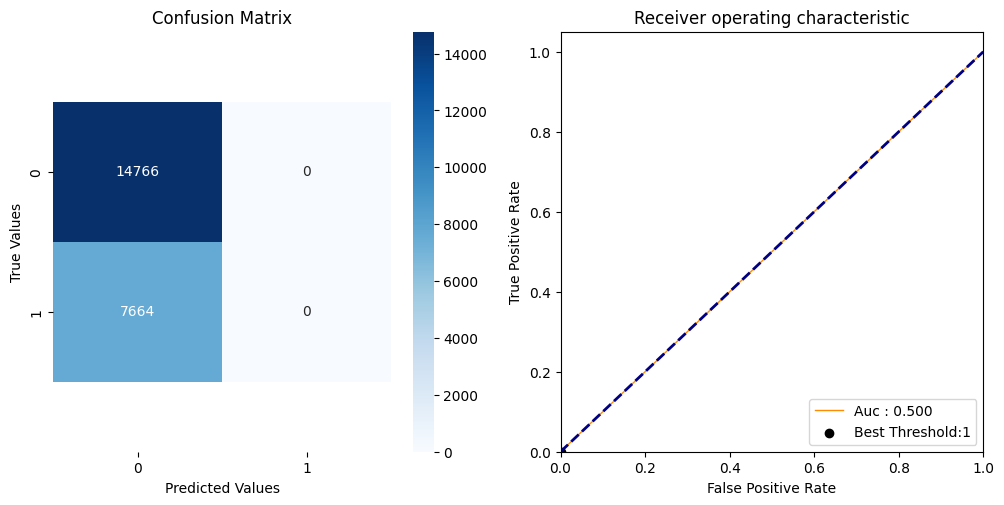

In [28]:
y_pred = model.predict(x_train > 0.5).astype("int32")
print_results(y_train, y_pred)